First, let's load all the required libraries and read in a collection at a target area. 

In [1]:

import ee
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
import folium
from IPython.display import Image
import xarray
import os
import geemap

start_time = time.perf_counter()

# Initialize the Earth Engine module.
ee.Initialize(project='corvus-phenology-drylands')

# Print metadata for a DEM dataset.
#print(ee.Image('USGS/SRTMGL1_003'))

print('')

# Target point 
target_point = ee.Geometry.Point(-115.56140, 32.790122)

# New dataset
lst_test = ee.ImageCollection('MODIS/061/MYD21A1D').filterBounds(target_point).filterDate(ee.Date("2000-01-01"), ee.Date("2024-12-31"))

before_resampling_time = time.perf_counter()

print('\nLoading libraries and imagery took about ', before_resampling_time - start_time, " seconds\n")

lst_region_test = lst_test.getRegion(target_point, 1000).getInfo()
spatial_sample_time = time.perf_counter()

print("\n First few lines of data extraction: \n", lst_region_test[:5], "\n")
print('\nGetting spatial sample took ', spatial_sample_time - before_resampling_time, " seconds\n")


/home/conor/miniconda3/envs/ecostress_gee/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)




Loading libraries and imagery took about  0.852868199988734  seconds


 First few lines of data extraction: 
 [['id', 'longitude', 'latitude', 'time', 'LST_1KM', 'QC', 'View_Angle', 'View_Time', 'Emis_29', 'Emis_31', 'Emis_32'], ['2002_07_04', -115.56376972555584, 32.792999446783135, 1025740800000, 335.08, 65472, 4, 13.200000000000001, 0.97, 0.976, 0.982], ['2002_07_05', -115.56376972555584, 32.792999446783135, 1025827200000, 322.40000000000003, 16064, 62, 13.9, 0.978, 0.966, 0.962], ['2002_07_06', -115.56376972555584, 32.792999446783135, 1025913600000, 334.68, 44736, -21, 13, 0.946, 0.968, 0.974], ['2002_07_07', -115.56376972555584, 32.792999446783135, 1026000000000, 329.3, 32481, 52, 13.700000000000001, 0.96, 0.976, 0.978]] 


Getting spatial sample took  85.2013993000146  seconds



Now we'll generate a data frame from the Earth Engine results and then create a figure showing the raw timeseries. 


 0           time   datetime  longitude   latitude  LST_1KM     QC  cloud_mask
0  1025740800000 2002-07-04 -115.56377  32.792999    61.93  65472           0
1  1025827200000 2002-07-05 -115.56377  32.792999    49.25  16064           0
2  1025913600000 2002-07-06 -115.56377  32.792999    61.53  44736           0
3  1026000000000 2002-07-07 -115.56377  32.792999    56.15  32481           0
4  1026086400000 2002-07-08 -115.56377  32.792999    57.93  48832           0

 (6040, 7)

Converting to Dataframe took  0.03177259999210946  seconds



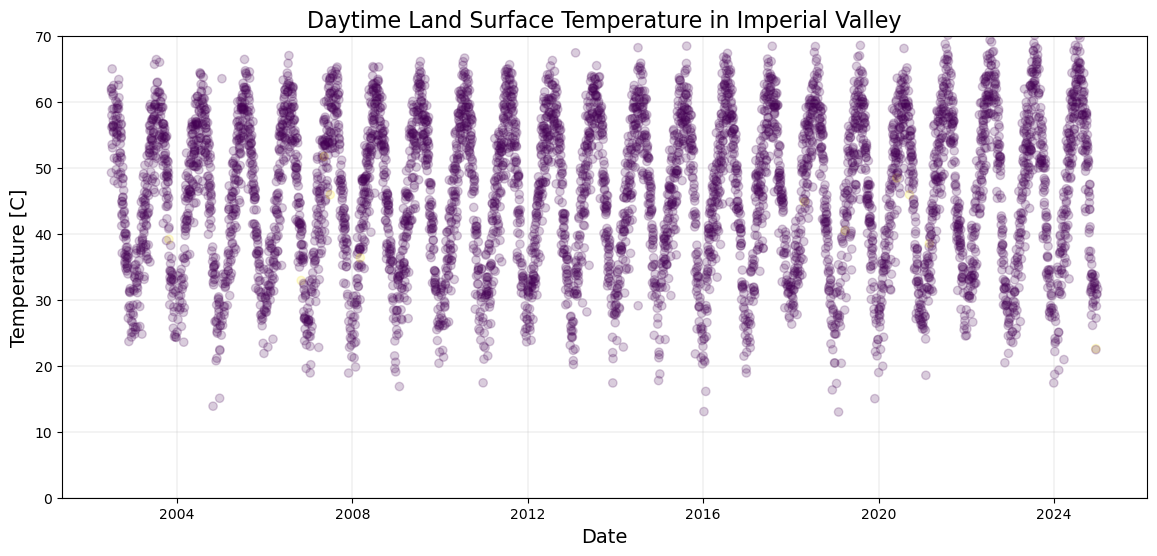

<Figure size 640x480 with 0 Axes>

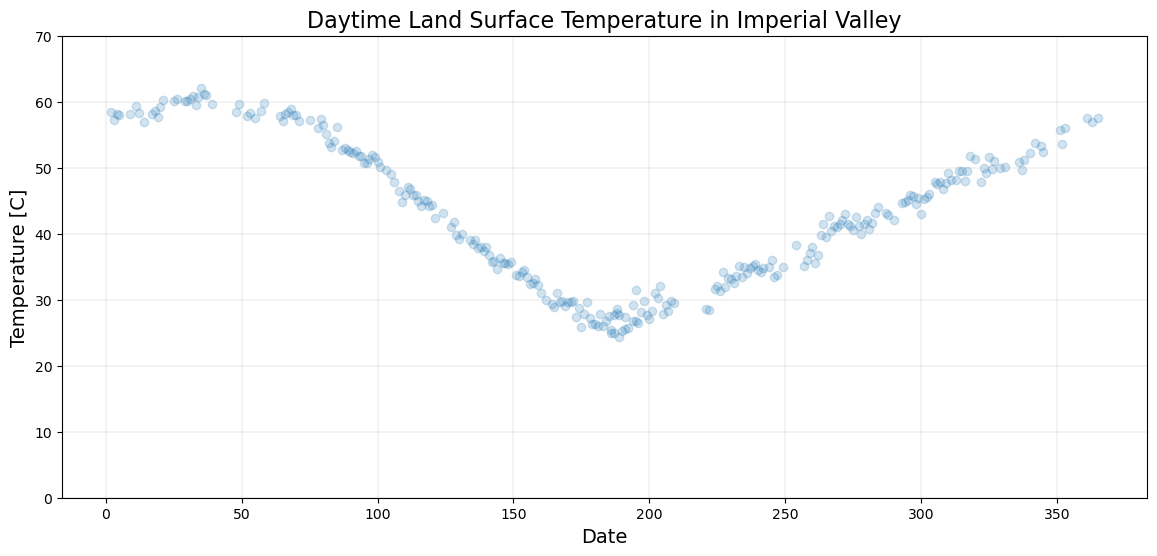

<Figure size 640x480 with 0 Axes>

In [2]:

def eeArrayToDF(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()
    
    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Add a field for cloud mask, from the QC band
    df['cloud_mask'] = (df['QC'].values >> 4) & 1
    
    # Keep the columns of interest.
    df = df[['time','datetime','longitude','latitude',*list_of_bands,'cloud_mask']]

    return df

lst_df = eeArrayToDF(lst_region_test, ['LST_1KM', 'QC'])

def tempMODIStoC(temp_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celcius = temp_modis - 273.15
    return t_celcius

# Apply the function to get temperature in Celsius
lst_df['LST_1KM'] = lst_df['LST_1KM'].apply(tempMODIStoC)

dataframe_time = time.perf_counter()

print("\n", lst_df.head())
print("\n", lst_df.shape)
print('\nConverting to Dataframe took ', dataframe_time - spatial_sample_time, " seconds\n")

# Subplots
fig, ax = plt.subplots(figsize=(14, 6))

# Add scatter plot
ax.scatter(lst_df['datetime'], lst_df['LST_1KM'], 
           c=lst_df['cloud_mask'], alpha=0.2, label='Urban (data)')

# Add some parameters
ax.set_title('Daytime Land Surface Temperature in Imperial Valley', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(0, 70)
ax.grid(lw=0.2)

plt.show()
plt.savefig('plot.png')

import datetime
lst_summary = lst_df
lst_summary['yday'] = lst_summary['datetime'].dt.dayofyear
lst_summary['LST_1KM_mean'] = lst_summary.groupby('yday')['LST_1KM'].mean()
print()

fig10, ax10 = plt.subplots(figsize=(14, 6))

# Add scatter plot
ax10.scatter(lst_summary['yday'], lst_summary['LST_1KM_mean'], alpha=0.2, label='Urban (data)')

# Add some parameters
ax10.set_title('Daytime Land Surface Temperature in Imperial Valley', fontsize=16)
ax10.set_xlabel('Date', fontsize=14)
ax10.set_ylabel('Temperature [C]', fontsize=14)
ax10.set_ylim(0, 70)
ax10.grid(lw=0.2)

plt.show()
plt.savefig('plot.png')

Last, we'll build a sinusoidal model for seasonal effects and use it to improve our long-term change estimates. 


 Params:  [ 4.12842084e+01 -3.07070033e+01  3.15620094e+10  1.43407390e+00
  8.03054697e-02] 


 Params Covariance:  [[ 1.87424064e-01  2.93896865e-03  7.60012157e+04  7.37728694e-04
  -4.23310279e-03]
 [ 2.93896865e-03  3.64845668e-02 -1.29576704e+04 -1.09977929e-04
  -1.50787400e-05]
 [ 7.60012157e+04 -1.29576704e+04  1.92764191e+13  1.67934386e+05
  -1.77685636e+03]
 [ 7.37728694e-04 -1.09977929e-04  1.67934386e+05  1.49502681e-03
  -1.72488916e-05]
 [-4.23310279e-03 -1.50787400e-05 -1.77685636e+03 -1.72488916e-05
   9.78014246e-05]] 

<bound method Series.unique of 470     39.15
1571    32.91
1763    51.71
1813    45.91
2063    36.35
5757    44.81
6097    40.45
6526    48.45
6631    45.91
6797    38.53
8166    22.59
Name: LST_1KM, dtype: float64>

Generating plot took  0.5133800000185147  seconds



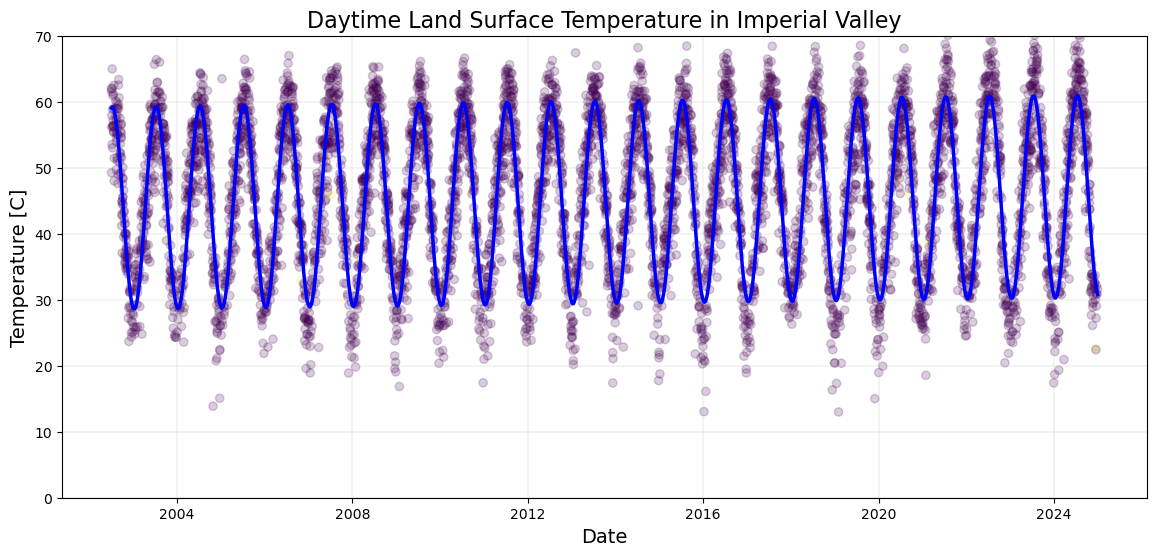


made it here



<Figure size 640x480 with 0 Axes>

In [3]:

# Generate a model using seasonal sinusoid to fit data
# Extract data
x_data = np.asanyarray(lst_df['time'].apply(float))
y_data = np.asanyarray(lst_df['LST_1KM'].apply(float))
# Fit sinusoid to time
lst_mean_0 = 40
lst_amplitude_0 = 40
tau_0 = 365*24*3600*1000
phi_0 = 2*np.pi*4*30.5*3600*1000/tau_0
slope_year_0 = 0.1

# Function to minimize seasonal effect parameters
def fit_func(t, lst_mean, lst_amplitude, tau, phi, slope_year):
    year = np.floor(t/365/24/3600/1000)
    return lst_mean + (lst_amplitude/2)*np.sin(2*np.pi*t/tau + phi) + year*slope_year

season_params, season_params_covariance = optimize.curve_fit(
    fit_func, x_data, y_data, p0=[lst_mean_0, lst_amplitude_0, tau_0, phi_0, slope_year_0])

print('\n Params: ', season_params, '\n')
print('\n Params Covariance: ', season_params_covariance, '\n')

lst_bad_df = lst_df[lst_df['cloud_mask'] == 1]
print(lst_bad_df['LST_1KM'].unique)

post_plot_time = time.perf_counter()

print('\nGenerating plot took ', post_plot_time - dataframe_time, " seconds\n")


# Subplots
fig2, ax2 = plt.subplots(figsize=(14, 6))

# Add scatter plot
ax2.scatter(lst_df['datetime'], lst_df['LST_1KM'], 
           c=lst_df['cloud_mask'], alpha=0.2, label='Urban (data)')
# Add seasonal line
ax2.plot(lst_df['datetime'],
        fit_func(x_data, season_params[0], season_params[1], season_params[2], season_params[3], season_params[4]),
        label="Fitted Seasonal Curve", color='blue', lw=2.5)


# Add some parameters
ax2.set_title('Daytime Land Surface Temperature in Imperial Valley', fontsize=16)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Temperature [C]', fontsize=14)
ax2.set_ylim(-0, 70)
ax2.grid(lw=0.2)
plt.show()
plt.savefig('plot_with_line.png')

print('\nmade it here\n')

Next we're inerested in understanding how much temporal autocorrelation there is in residuals

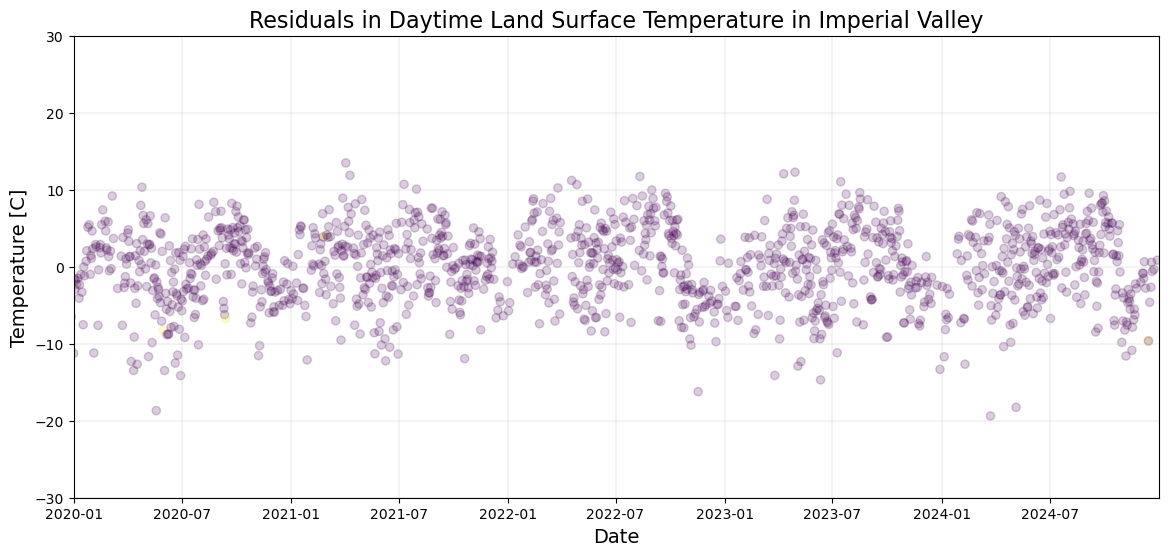


Residual root mean square error is  4.950522697729063 

[ 0.28589253  0.37032177  0.17878569  0.17833193  0.18893042  0.12799986
  0.20960628  0.09885926  0.1684824   0.10649337  0.13910556  0.13245151
  0.101106    0.13152678  0.08408417  0.11665419  0.07027903  0.0965616
  0.08230153  0.06952487  0.07804632  0.06467086  0.06831627  0.04775914
  0.06346789  0.04437845  0.03183052  0.02942356  0.02565063  0.01630735
  0.01382551  0.01390936  0.01039456 -0.00311193 -0.01354868 -0.01284991
 -0.02018656 -0.01598577 -0.03473624 -0.02333171 -0.03249474 -0.03514227
 -0.04466839 -0.03748254 -0.05756728 -0.04223821 -0.06655544 -0.0442971
 -0.05745396 -0.07805949 -0.0733365  -0.10257105 -0.06846755 -0.08279073
 -0.0628862  -0.10222157 -0.09794445 -0.09967917 -0.10005262]
 6040


<Figure size 640x480 with 0 Axes>

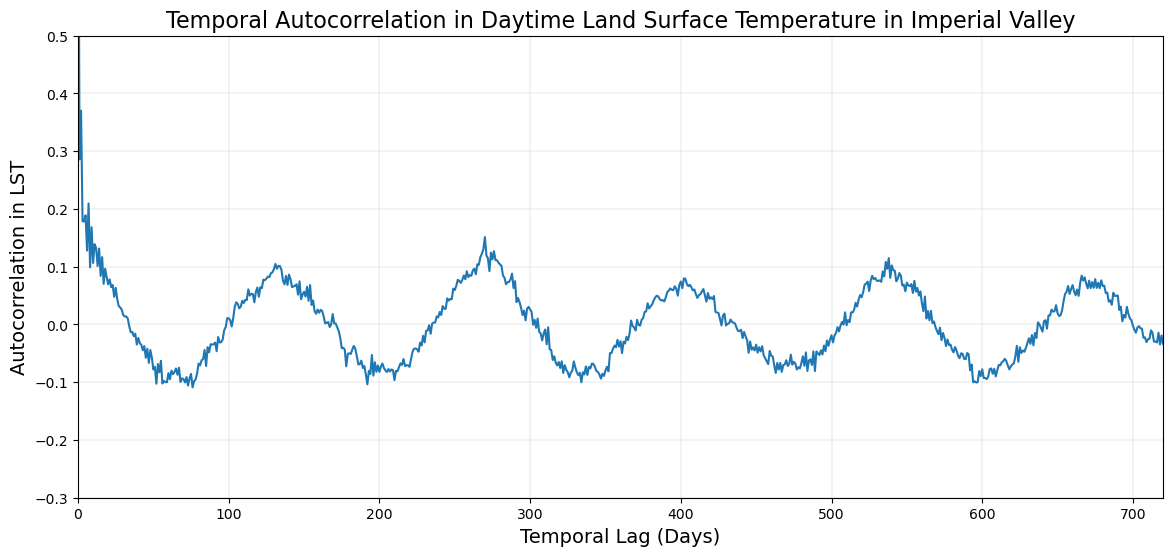


made it here



<Figure size 640x480 with 0 Axes>

In [4]:
lst_df['LST_pred'] = fit_func(x_data, season_params[0], season_params[1], season_params[2], season_params[3], season_params[4])
lst_df['LST_resid'] = lst_df['LST_1KM'] - lst_df['LST_pred']

# Subplots
fig3, ax3 = plt.subplots(figsize=(14, 6))

# Add scatter plot
ax3.scatter(lst_df['datetime'], lst_df['LST_resid'], 
           c=lst_df['cloud_mask'], alpha=0.2, label='Urban (data)')

# Add some parameters
ax3.set_title('Residuals in Daytime Land Surface Temperature in Imperial Valley', fontsize=16)
ax3.set_xlabel('Date', fontsize=14)
ax3.set_ylabel('Temperature [C]', fontsize=14)
ax3.set_ylim(-30, 30)
ax3.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2024-12-31'))
ax3.grid(lw=0.2)
plt.show()
plt.savefig('plot_residuals.png')

rmse = ((lst_df['LST_resid']**2).mean())**0.5
print('\nResidual root mean square error is ', rmse, '\n')

# Get the temporal autocorrelation across time lags
resid_values = lst_df['LST_resid']
#max_lag = 100
#function
#resid_corrs = np.corrcoef(resid_values[0:(resid_values.shape[0]-max_lag-1)],
#                          resid_values[(max_lag-1):(resid_values.shape[0])])
#print(resid_corrs)

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]
resid_autocorr = autocorr(resid_values)
print((resid_autocorr/(resid_autocorr.max()))[1:60])

# Subplots
fig4, ax4 = plt.subplots(figsize=(14, 6))
print('', resid_autocorr.shape[0])
# Add scatter plot
ax4.plot(np.arange(0,(resid_autocorr.shape[0])), resid_autocorr / float(resid_autocorr.max()))

# Add some parameters
ax4.set_title('Temporal Autocorrelation in Daytime Land Surface Temperature in Imperial Valley', fontsize=16)
ax4.set_xlabel('Temporal Lag (Days)', fontsize=14)
ax4.set_ylabel('Autocorrelation in LST', fontsize=14)
ax4.set_ylim(-0.3, 0.5)
ax4.set_xlim(0, 720)
ax4.grid(lw=0.2)
plt.show()
plt.savefig('residual_autocorrelation.png')

print('\nmade it here\n')


LinregressResult(slope=np.float64(0.027091669684739573), intercept=np.float64(0.028935882734257352), rvalue=np.float64(0.026855821956492137), pvalue=np.float64(0.05910281534431215), stderr=np.float64(0.014350436432610726), intercept_stderr=np.float64(0.07112661998497517))
 6040


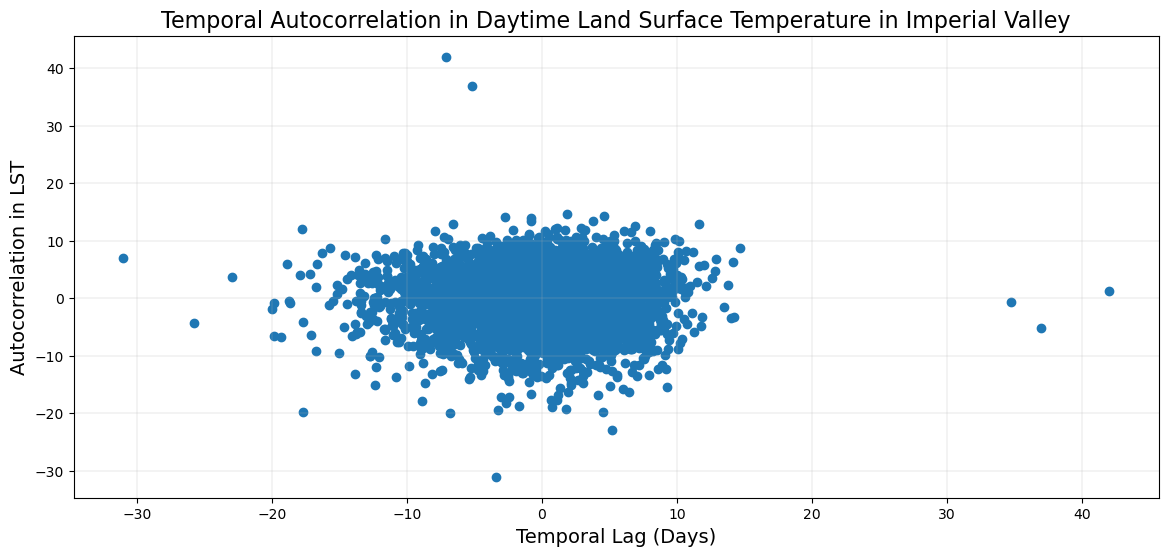


made it here



<Figure size 640x480 with 0 Axes>

In [5]:

from scipy.stats import linregress

lag = 1100

test_data = np.stack((resid_values[0:(resid_values.shape[0]-lag)], 
                resid_values[(0+lag):(resid_values.shape[0]+lag)]), 
                axis=1)
output = linregress(resid_values[0:(resid_values.shape[0]-lag)], resid_values[(0+lag):(resid_values.shape[0]+lag)])
print(output)


# Subplots
fig5, ax5 = plt.subplots(figsize=(14, 6))
print('', resid_autocorr.shape[0])
# Add scatter plot

ax5.scatter(resid_values[0:(resid_values.shape[0]-lag)],
            resid_values[(0+lag):(resid_values.shape[0]+lag)])

# Add some parameters
ax5.set_title('Temporal Autocorrelation in Daytime Land Surface Temperature in Imperial Valley', fontsize=16)
ax5.set_xlabel('Temporal Lag (Days)', fontsize=14)
ax5.set_ylabel('Autocorrelation in LST', fontsize=14)
#ax5.set_ylim(-0.3, 0.5)
#ax5.set_xlim(0, 60)
ax5.grid(lw=0.2)
plt.show()
plt.savefig('autocorrelation_scatter.png')

print('\nmade it here\n')

Also we can try applying a seasonal mann kendall test:

In [6]:
import pymannkendall as mk

print(mk.original_test(lst_df['LST_1KM']))

print(mk.seasonal_test(lst_df['LST_1KM'], period=365))

print(mk.correlated_seasonal_test(lst_df['LST_1KM'], period=365))

print(mk.partial_test(np.stack((lst_df['LST_1KM'], lst_df['time']), axis=1)))

Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(0.00013437306602348542), z=np.float64(3.8183025571056577), Tau=np.float64(0.03276325298364165), s=np.float64(597529.0), var_s=np.float64(24489270335.0), slope=np.float64(0.00032855280312907195), intercept=np.float64(46.997934810951776))
Seasonal_Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(3.210295566913324e-05), z=np.float64(4.158011720455983), Tau=np.float64(0.03951063829787234), s=np.float64(1857.0), var_s=np.float64(199243.66666666756), slope=np.float64(0.14666666666666592), intercept=np.float64(46.776684931506864))
Correlated_Seasonal_Mann_Kendall_test(trend='no trend', h=np.False_, p=np.float64(0.5910817906765291), z=np.float64(0.5372690358756436), Tau=np.float64(0.019246575342465752), s=np.float64(843.0), var_s=np.float64(2461906.333333334), slope=np.float64(0.14666666666666592), intercept=np.float64(46.776684931506864))
Partial_Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.0748331

Let's experiment a bit with Fourier regression as well

/tmp/ipykernel_30102/273247356.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  lst_subset['LST_1KM'][0] = np.mean(lst_subset['LST_1KM'][range(0,2)])
/tmp/ipykernel_30102/273247356.py:9: SettingWithCopyWarning: 
A value is trying to be se

B_1_ 1  =  -26.878827090093477
B_2_ 1  =  -3.207083640879134
B_1_ 2  =  -5.539181475503544
B_2_ 2  =  -1.2522548823690878
B_1_ 3  =  -1.5264127621919024
B_2_ 3  =  3.841303861665774
B_1_ 4  =  0.5033244379400412
B_2_ 4  =  -0.37468389882442266
B_1_ 5  =  -0.4259536860141162
B_2_ 5  =  1.2641493012931666
B_1_ 6  =  0.4548039737481598
B_2_ 6  =  -0.03216367177125
B_1_ 7  =  -0.8039743983252944
B_2_ 7  =  0.5032162061520049
B_1_ 8  =  0.5176764339183006
B_2_ 8  =  -0.8015493231639541
B_1_ 9  =  0.23444560286813873
B_2_ 9  =  -0.15948660900156483
B_1_ 10  =  0.4868078208665341
B_2_ 10  =  0.7886975883664805
B_1_ 11  =  0.41993221571871375
B_2_ 11  =  0.17449650058656227
B_1_ 12  =  -0.7284937541220845
B_2_ 12  =  -0.6096671140188701
B_1_ 13  =  0.12516855587392176
B_2_ 13  =  0.8281217667405254
B_1_ 14  =  -0.3252241857910783
B_2_ 14  =  0.5291098844885328
B_1_ 15  =  0.12392894439829455
B_2_ 15  =  -0.5418922616555636
B_1_ 16  =  -0.3015662933114791
B_2_ 16  =  -0.5599949359692641
B_1_ 17

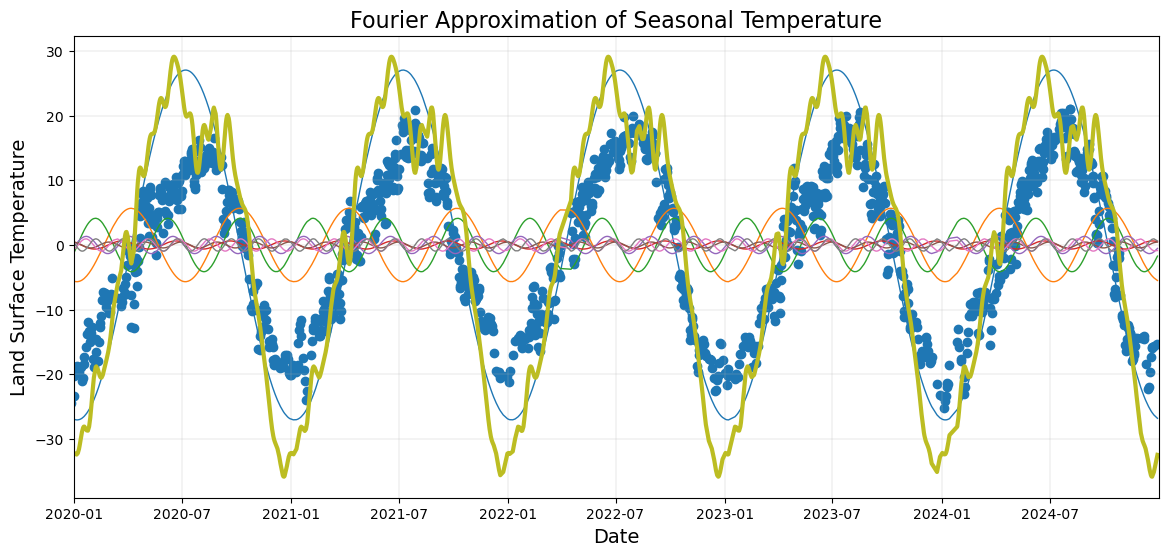


made it here



<Figure size 640x480 with 0 Axes>

In [118]:

lst_subset = lst_df[lst_df['datetime'] >= "2003-01-01 00:00:00"]
lst_subset = lst_subset.reset_index(drop=True)

n_samp = lst_subset['LST_1KM'].size
N =  365 #lst_df['LST_1KM'].size
lst_subset['index_without_gaps'] = range(0,n_samp)

# Try applying a median filter - see what this does
lst_subset['LST_1KM'][0] = np.mean(lst_subset['LST_1KM'][range(0,2)])
for i in range(1,n_samp-1):
    lst_subset['LST_1KM'][i] = np.mean(lst_subset['LST_1KM'][range(i-1,i+2)])
lst_subset['LST_1KM'][n_samp-1] = np.mean(lst_subset['LST_1KM'][range(n_samp-2,n_samp)])

# get b value for fourier transform
def getFourierCoeff(j):
    B_1_j_num = 0
    for t in range(1,n_samp):
        doy = (lst_subset['datetime'][t].day_of_year)
        B_1_j_num = B_1_j_num + lst_subset.loc[lst_subset['index_without_gaps'] == t]['LST_1KM'].values[0] * np.cos(2*np.pi*doy*j/N)
    B_1_j_den = 0
    for t in range(1,n_samp):
        doy = (lst_subset['datetime'][t].day_of_year)
        B_1_j_den = B_1_j_den + np.cos(2*np.pi*doy*j/N)**2
    B_1_j = B_1_j_num / B_1_j_den
    print('B_1_',j,' = ',B_1_j)
    
    B_2_j_num = 0
    for t in range(1,n_samp):
        doy = (lst_subset['datetime'][t].day_of_year)
        B_2_j_num = B_2_j_num + lst_subset.loc[lst_subset['index_without_gaps'] == t]['LST_1KM'].values[0] * np.sin(2*np.pi*doy*j/N)
    B_2_j_den = 0
    for t in range(1,n_samp):
        doy = (lst_subset['datetime'][t].day_of_year)
        B_2_j_den = B_2_j_den + np.sin(2*np.pi*doy*j/N)**2
    B_2_j = B_2_j_num / B_2_j_den
    print('B_2_',j,' = ',B_2_j)

    return B_1_j, B_2_j

B_1_1, B_2_1 = getFourierCoeff(1)
B_1_2, B_2_2 = getFourierCoeff(2)
B_1_3, B_2_3 = getFourierCoeff(3)
B_1_4, B_2_4 = getFourierCoeff(4)
B_1_5, B_2_5 = getFourierCoeff(5)
B_1_6, B_2_6 = getFourierCoeff(6)
B_1_7, B_2_7 = getFourierCoeff(7)
B_1_8, B_2_8 = getFourierCoeff(8)
B_1_9, B_2_9 = getFourierCoeff(9)
B_1_10, B_2_10 = getFourierCoeff(10)
B_1_11, B_2_11 = getFourierCoeff(11)
B_1_12, B_2_12 = getFourierCoeff(12)
B_1_13, B_2_13 = getFourierCoeff(13)
B_1_14, B_2_14 = getFourierCoeff(14)
B_1_15, B_2_15 = getFourierCoeff(15)
B_1_16, B_2_16 = getFourierCoeff(16)
B_1_17, B_2_17 = getFourierCoeff(17)
B_1_18, B_2_18 = getFourierCoeff(18)
B_1_19, B_2_19 = getFourierCoeff(19)
B_1_20, B_2_20 = getFourierCoeff(20)

# Subplots
fig6, ax6 = plt.subplots(figsize=(14, 6))

x_val = np.array(range(0,n_samp))
doy_val = lst_subset['datetime'].dt.day_of_year
y_comp_1 = B_1_1 * np.cos(2*np.pi*doy_val*1/N) + B_2_1 * np.sin(2*np.pi*doy_val*1/N)
y_comp_2 = B_1_2 * np.cos(2*np.pi*doy_val*2/N) + B_2_2 * np.sin(2*np.pi*doy_val*2/N)
y_comp_3 = B_1_3 * np.cos(2*np.pi*doy_val*3/N) + B_2_3 * np.sin(2*np.pi*doy_val*3/N)
y_comp_4 = B_1_4 * np.cos(2*np.pi*doy_val*4/N) + B_2_4 * np.sin(2*np.pi*doy_val*4/N)
y_comp_5 = B_1_5 * np.cos(2*np.pi*doy_val*5/N) + B_2_5 * np.sin(2*np.pi*doy_val*5/N)
y_comp_6 = B_1_6 * np.cos(2*np.pi*doy_val*6/N) + B_2_6 * np.sin(2*np.pi*doy_val*6/N)
y_comp_7 = B_1_7 * np.cos(2*np.pi*doy_val*7/N) + B_2_7 * np.sin(2*np.pi*doy_val*7/N)
y_comp_8 = B_1_8 * np.cos(2*np.pi*doy_val*8/N) + B_2_8 * np.sin(2*np.pi*doy_val*8/N)
y_comp_9 = B_1_9 * np.cos(2*np.pi*doy_val*9/N) + B_2_9 * np.sin(2*np.pi*doy_val*9/N)
y_comp_10 = B_1_10 * np.cos(2*np.pi*doy_val*10/N) + B_2_10 * np.sin(2*np.pi*doy_val*10/N)
y_comp_11 = B_1_11 * np.cos(2*np.pi*doy_val*11/N) + B_2_11 * np.sin(2*np.pi*doy_val*11/N)
y_comp_12 = B_1_12 * np.cos(2*np.pi*doy_val*12/N) + B_2_12 * np.sin(2*np.pi*doy_val*12/N)
y_comp_13 = B_1_13 * np.cos(2*np.pi*doy_val*13/N) + B_2_13 * np.sin(2*np.pi*doy_val*13/N)
y_comp_14 = B_1_14 * np.cos(2*np.pi*doy_val*14/N) + B_2_14 * np.sin(2*np.pi*doy_val*14/N)
y_comp_15 = B_1_15 * np.cos(2*np.pi*doy_val*15/N) + B_2_15 * np.sin(2*np.pi*doy_val*15/N)
y_comp_16 = B_1_16 * np.cos(2*np.pi*doy_val*16/N) + B_2_16 * np.sin(2*np.pi*doy_val*16/N)
y_comp_17 = B_1_17 * np.cos(2*np.pi*doy_val*17/N) + B_2_17 * np.sin(2*np.pi*doy_val*17/N)
y_comp_18 = B_1_18 * np.cos(2*np.pi*doy_val*18/N) + B_2_18 * np.sin(2*np.pi*doy_val*18/N)
y_comp_19 = B_1_19 * np.cos(2*np.pi*doy_val*19/N) + B_2_19 * np.sin(2*np.pi*doy_val*19/N)
y_comp_20 = B_1_20 * np.cos(2*np.pi*doy_val*20/N) + B_2_20 * np.sin(2*np.pi*doy_val*20/N)
y_full = (y_comp_1 + y_comp_2 + y_comp_3 + y_comp_4 + y_comp_5 + y_comp_6 + y_comp_7 + y_comp_8 + y_comp_9 + y_comp_10 + 
          y_comp_11 + y_comp_12 + y_comp_13 + y_comp_14 + y_comp_15 + y_comp_16 + y_comp_17 + y_comp_18 + y_comp_19 + y_comp_20)
lst_norm = (lst_subset['LST_1KM'] - np.mean(lst_subset['LST_1KM']))

ax6.scatter(lst_subset['datetime'], lst_norm)
ax6.plot(lst_subset['datetime'], y_comp_1, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_comp_2, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_comp_3, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_comp_4, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_comp_5, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_comp_6, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_comp_7, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_comp_8, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_full, linewidth = 3, )
# Add some parameters
ax6.set_title('Fourier Approximation of Seasonal Temperature', fontsize=16)
ax6.set_xlabel('Date', fontsize=14)
ax6.set_ylabel('Land Surface Temperature', fontsize=14)
#ax6.set_ylim(-0.3, 0.5)
ax6.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2024-12-31'))
ax6.grid(lw=0.2)
plt.show()
plt.savefig('fourier_decomposition.png')

print('\nmade it here\n')


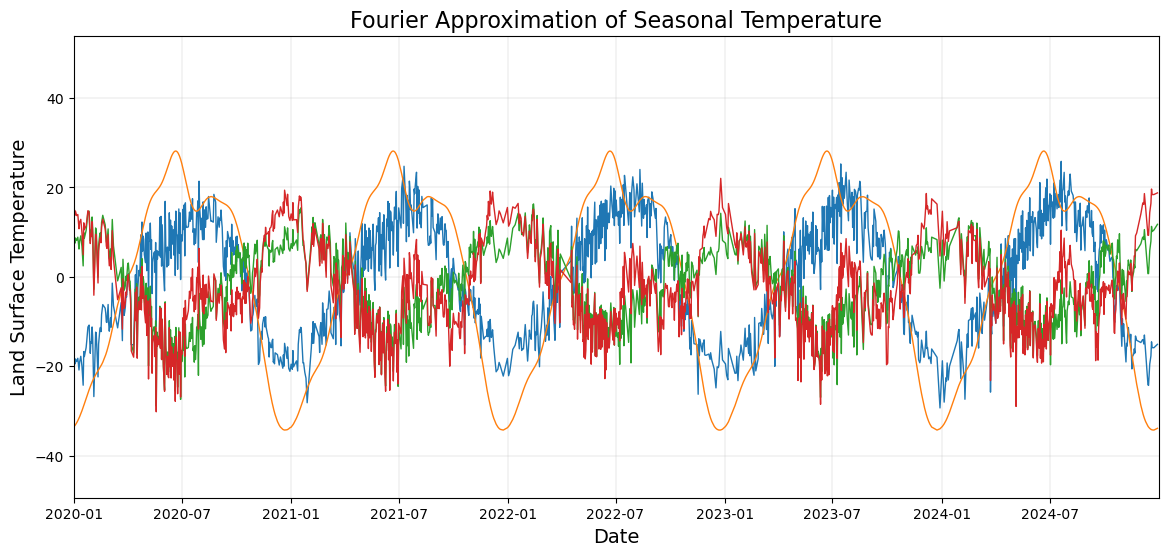

In [115]:
# Subplots
fig6, ax6 = plt.subplots(figsize=(14, 6))

x_val = np.array(range(0,n_samp))
doy_val = lst_subset['datetime'].dt.day_of_year
y_comp_1 = B_1_1 * np.cos(2*np.pi*doy_val*1/N) + B_2_1 * np.sin(2*np.pi*doy_val*1/N)
y_comp_2 = B_1_2 * np.cos(2*np.pi*doy_val*2/N) + B_2_2 * np.sin(2*np.pi*doy_val*2/N)
y_comp_3 = B_1_3 * np.cos(2*np.pi*doy_val*3/N) + B_2_3 * np.sin(2*np.pi*doy_val*3/N)
y_comp_4 = B_1_4 * np.cos(2*np.pi*doy_val*4/N) + B_2_4 * np.sin(2*np.pi*doy_val*4/N)
y_comp_5 = B_1_5 * np.cos(2*np.pi*doy_val*5/N) + B_2_5 * np.sin(2*np.pi*doy_val*5/N)
y_comp_6 = B_1_6 * np.cos(2*np.pi*doy_val*6/N) + B_2_6 * np.sin(2*np.pi*doy_val*6/N)
y_comp_7 = B_1_7 * np.cos(2*np.pi*doy_val*7/N) + B_2_7 * np.sin(2*np.pi*doy_val*7/N)
y_comp_8 = B_1_8 * np.cos(2*np.pi*doy_val*8/N) + B_2_8 * np.sin(2*np.pi*doy_val*8/N)
y_full = y_comp_1 + y_comp_2 + y_comp_3 + y_comp_4 + y_comp_5 + y_comp_6 + y_comp_7 + y_comp_8
lst_norm = (lst_subset['LST_1KM'] - np.mean(lst_subset['LST_1KM']))

ax6.plot(lst_subset['datetime'], lst_norm, linewidth = 1)
ax6.plot(lst_subset['datetime'], y_full, linewidth = 1)
ax6.plot(lst_subset['datetime'], lst_norm - y_comp_1, linewidth = 1)
ax6.plot(lst_subset['datetime'], lst_norm - y_full, linewidth = 1)
# Add some parameters
ax6.set_title('Fourier Approximation of Seasonal Temperature', fontsize=16)
ax6.set_xlabel('Date', fontsize=14)
ax6.set_ylabel('Land Surface Temperature', fontsize=14)
#ax6.set_ylim(-0.3, 0.5)
ax6.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2024-12-31'))
ax6.grid(lw=0.2)
plt.show()



366
<class 'numpy.ndarray'>
366
[25.37       24.88666667 28.59545455 24.328      23.53666667 25.50833333
 25.4425     25.12454545 26.83666667 26.82333333 26.4       ]
388
6040
6040
6060
6040
[  10   11   12 ... 6047 6048 6049]


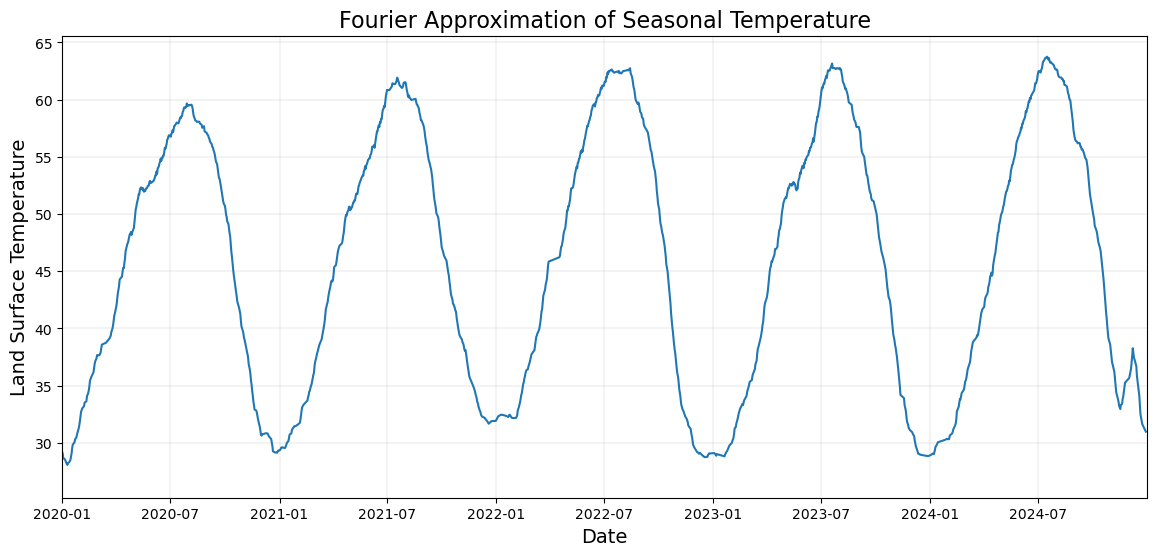

In [8]:

n_total = lst_df['LST_1KM'].size
lst_df_doy = lst_df
lst_df_doy['doy'] = lst_df['datetime'].dt.day_of_year
daily_LST = np.array(lst_df_doy[['doy','LST_1KM']].groupby('doy').mean()).flatten()
print(daily_LST.size)

# Try applying a smoothing filter - see what this does
def smooth(y, window_size):
    window_weights = np.ones(window_size) / window_size
    y_smooth = np.convolve(y, window_weights, mode='same')
    return y_smooth

#print(355:366)
print(type(daily_LST))
print(daily_LST.size)
print(daily_LST[355:366])

padded_daily_LST = np.concatenate((daily_LST[355:366], daily_LST, daily_LST[0:11]))
print(padded_daily_LST.size)
daily_LST_smoothed = smooth(np.array(padded_daily_LST).flatten(), 20)[11:377]


LST_arr = np.array(lst_df['LST_1KM']).flatten()
overall_LST_padded = np.concatenate((LST_arr[(n_total-10):(n_total-1)], LST_arr, LST_arr[0:11])) 
overall_LST_smoothed = smooth(np.array(overall_LST_padded).flatten(), 40)[10:(n_total+10)]

print(n_total)
print(LST_arr.size)
print(overall_LST_padded.size)
print(overall_LST_smoothed.size)
print(np.arange(0,1000000)[10:(n_total+10)])

# Subplots
fig6, ax6 = plt.subplots(figsize=(14, 6))

#ax6.plot(range(1,367), daily_LST)
ax6.plot(lst_df['datetime'], overall_LST_smoothed)
# Add some parameters
ax6.set_title('Fourier Approximation of Seasonal Temperature', fontsize=16)
ax6.set_xlabel('Date', fontsize=14)
ax6.set_ylabel('Land Surface Temperature', fontsize=14)
ax6.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2024-12-31'))
ax6.grid(lw=0.2)
plt.show()

44.809598272792016
46.697137028581125
B_1_ 1  =  -14.386526704844824
B_2_ 1  =  -2.195609247109691
B_1_ 2  =  1.202977698951624
B_2_ 2  =  1.5323922340698117
B_1_ 3  =  1.1802107251734741
B_2_ 3  =  0.44892863141901884
B_1_ 4  =  0.7706209554930354
B_2_ 4  =  -0.8530799143722406
B_1_ 5  =  -0.028521161924296472
B_2_ 5  =  -0.223253488144422
B_1_ 6  =  0.2042938225086825
B_2_ 6  =  -0.343929838604443
B_1_ 7  =  -0.17118759155623145
B_2_ 7  =  0.03963651310423201
B_1_ 8  =  0.1171160272403992
B_2_ 8  =  -0.061468538375673176
B_1_ 9  =  -0.22731210431042856
B_2_ 9  =  0.07401363735767073
B_1_ 10  =  -0.01851471814877061
B_2_ 10  =  0.10608263653592827
B_1_ 11  =  0.03950389938482451
B_2_ 11  =  -0.1152524427523481
B_1_ 12  =  -0.0873952046353963
B_2_ 12  =  -0.07415967710499002
B_1_ 13  =  0.1497568562397843
B_2_ 13  =  -0.004689891761676308
B_1_ 14  =  0.07624660501556967
B_2_ 14  =  -0.032704977299660355
B_1_ 15  =  0.10956029835835038
B_2_ 15  =  -0.057227274081959094
B_1_ 16  =  -0.09

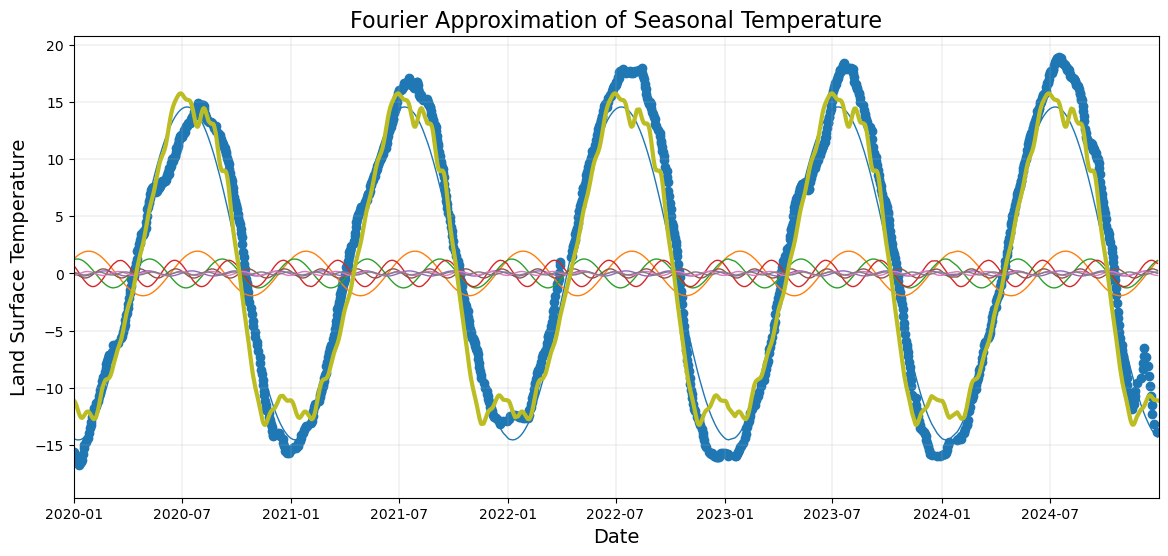


made it here

1.6918386121737958


<Figure size 640x480 with 0 Axes>

In [9]:

lst_smoothed_df = lst_df
lst_smoothed_df['lst_smoothed'] = overall_LST_smoothed

lst_subset_smoothed = lst_smoothed_df[lst_smoothed_df['datetime'] >= "2003-01-01 00:00:00"]
lst_subset_smoothed = lst_subset_smoothed.reset_index(drop=True)
mean_daily_lst = lst_subset_smoothed.groupby('doy')['lst_smoothed'].mean()
print(mean_daily_lst.mean())
print(np.mean(lst_subset_smoothed['lst_smoothed']))
lst_subset_smoothed['lst_smoothed'] = lst_subset_smoothed['lst_smoothed'] - mean_daily_lst.mean() #np.mean(lst_subset_smoothed['lst_smoothed'])

n_samp = lst_subset_smoothed['lst_smoothed'].size
N =  366 #lst_df['LST_1KM'].size
lst_subset_smoothed['index_without_gaps'] = range(0,n_samp)

# get b value for fourier transform
def getFourierCoeff(j):
    B_1_j_num = 0
    B_1_j_den = 0
    for t in range(1,n_samp):
        doy = (lst_subset_smoothed['datetime'][t].day_of_year)
        B_1_j_num = B_1_j_num + lst_subset_smoothed['lst_smoothed'][t] * np.cos(2*np.pi*doy*j/N)
        B_1_j_den = B_1_j_den + pow(np.cos(2*np.pi*doy*j/N),2)
    B_1_j = B_1_j_num / B_1_j_den
    print('B_1_',j,' = ',B_1_j)
    
    B_2_j_num = 0
    B_2_j_den = 0
    for t in range(1,n_samp):
        doy = (lst_subset_smoothed['datetime'][t].day_of_year)
        B_2_j_num = B_2_j_num + lst_subset_smoothed['lst_smoothed'][t] * np.sin(2*np.pi*doy*j/N)
        B_2_j_den = B_2_j_den + pow(np.sin(2*np.pi*doy*j/N),2)
    B_2_j = B_2_j_num / B_2_j_den
    print('B_2_',j,' = ',B_2_j)

    return B_1_j, B_2_j

B_1_1, B_2_1 = getFourierCoeff(1)
B_1_2, B_2_2 = getFourierCoeff(2)
B_1_3, B_2_3 = getFourierCoeff(3)
B_1_4, B_2_4 = getFourierCoeff(4)
B_1_5, B_2_5 = getFourierCoeff(5)
B_1_6, B_2_6 = getFourierCoeff(6)
B_1_7, B_2_7 = getFourierCoeff(7)
B_1_8, B_2_8 = getFourierCoeff(8)
B_1_9, B_2_9 = getFourierCoeff(9)
B_1_10, B_2_10 = getFourierCoeff(10)
B_1_11, B_2_11 = getFourierCoeff(11)
B_1_12, B_2_12 = getFourierCoeff(12)
B_1_13, B_2_13 = getFourierCoeff(13)
B_1_14, B_2_14 = getFourierCoeff(14)
B_1_15, B_2_15 = getFourierCoeff(15)
B_1_16, B_2_16 = getFourierCoeff(16)
B_1_17, B_2_17 = getFourierCoeff(17)
B_1_18, B_2_18 = getFourierCoeff(18)
B_1_19, B_2_19 = getFourierCoeff(19)
B_1_20, B_2_20 = getFourierCoeff(20)

# Subplots
fig6, ax6 = plt.subplots(figsize=(14, 6))

x_val = np.array(range(0,n_samp))
doy_val = lst_subset_smoothed['datetime'].dt.day_of_year
y_comp_1 = B_1_1 * np.cos(2*np.pi*doy_val*1/N) + B_2_1 * np.sin(2*np.pi*doy_val*1/N)
y_comp_2 = B_1_2 * np.cos(2*np.pi*doy_val*2/N) + B_2_2 * np.sin(2*np.pi*doy_val*2/N)
y_comp_3 = B_1_3 * np.cos(2*np.pi*doy_val*3/N) + B_2_3 * np.sin(2*np.pi*doy_val*3/N)
y_comp_4 = B_1_4 * np.cos(2*np.pi*doy_val*4/N) + B_2_4 * np.sin(2*np.pi*doy_val*4/N)
y_comp_5 = B_1_5 * np.cos(2*np.pi*doy_val*5/N) + B_2_5 * np.sin(2*np.pi*doy_val*5/N)
y_comp_6 = B_1_6 * np.cos(2*np.pi*doy_val*6/N) + B_2_6 * np.sin(2*np.pi*doy_val*6/N)
y_comp_7 = B_1_7 * np.cos(2*np.pi*doy_val*7/N) + B_2_7 * np.sin(2*np.pi*doy_val*7/N)
y_comp_8 = B_1_8 * np.cos(2*np.pi*doy_val*8/N) + B_2_8 * np.sin(2*np.pi*doy_val*8/N)
y_comp_9 = B_1_9 * np.cos(2*np.pi*doy_val*9/N) + B_2_9 * np.sin(2*np.pi*doy_val*9/N)
y_comp_10 = B_1_10 * np.cos(2*np.pi*doy_val*10/N) + B_2_10 * np.sin(2*np.pi*doy_val*10/N)
y_comp_11 = B_1_11 * np.cos(2*np.pi*doy_val*11/N) + B_2_11 * np.sin(2*np.pi*doy_val*11/N)
y_comp_12 = B_1_12 * np.cos(2*np.pi*doy_val*12/N) + B_2_12 * np.sin(2*np.pi*doy_val*12/N)
y_comp_13 = B_1_13 * np.cos(2*np.pi*doy_val*13/N) + B_2_13 * np.sin(2*np.pi*doy_val*13/N)
y_comp_14 = B_1_14 * np.cos(2*np.pi*doy_val*14/N) + B_2_14 * np.sin(2*np.pi*doy_val*14/N)
y_comp_15 = B_1_15 * np.cos(2*np.pi*doy_val*15/N) + B_2_15 * np.sin(2*np.pi*doy_val*15/N)
y_comp_16 = B_1_16 * np.cos(2*np.pi*doy_val*16/N) + B_2_16 * np.sin(2*np.pi*doy_val*16/N)
y_comp_17 = B_1_17 * np.cos(2*np.pi*doy_val*17/N) + B_2_17 * np.sin(2*np.pi*doy_val*17/N)
y_comp_18 = B_1_18 * np.cos(2*np.pi*doy_val*18/N) + B_2_18 * np.sin(2*np.pi*doy_val*18/N)
y_comp_19 = B_1_19 * np.cos(2*np.pi*doy_val*19/N) + B_2_19 * np.sin(2*np.pi*doy_val*19/N)
y_comp_20 = B_1_20 * np.cos(2*np.pi*doy_val*20/N) + B_2_20 * np.sin(2*np.pi*doy_val*20/N)
y_full = (y_comp_1 + y_comp_2 + y_comp_3 + y_comp_4 + y_comp_5 + y_comp_6 + y_comp_7 + y_comp_8 + y_comp_9 + y_comp_10 + 
          y_comp_11 + y_comp_12 + y_comp_13 + y_comp_14 + y_comp_15 + y_comp_16 + y_comp_17 + y_comp_18 + y_comp_19 + y_comp_20)

lst_norm = lst_subset_smoothed['lst_smoothed'] # - np.mean(lst_subset_smoothed['lst_smoothed'])

ax6.scatter(lst_subset_smoothed['datetime'], lst_norm)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_1, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_2, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_3, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_4, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_5, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_6, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_7, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_comp_8, linewidth = 1)
ax6.plot(lst_subset_smoothed['datetime'], y_full, linewidth = 3, )
#ax6.plot(lst_subset_smoothed['datetime'], y_comp_1 + y_comp_2 + y_comp_3 + y_comp_4, linewidth = 3, )
# Add some parameters
ax6.set_title('Fourier Approximation of Seasonal Temperature', fontsize=16)
ax6.set_xlabel('Date', fontsize=14)
ax6.set_ylabel('Land Surface Temperature', fontsize=14)
#ax6.set_ylim(-0.3, 0.5)
ax6.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2024-12-31'))
ax6.grid(lw=0.2)
plt.show()
plt.savefig('fourier_decomposition.png')

print('\nmade it here\n')

print(np.mean(y_full))

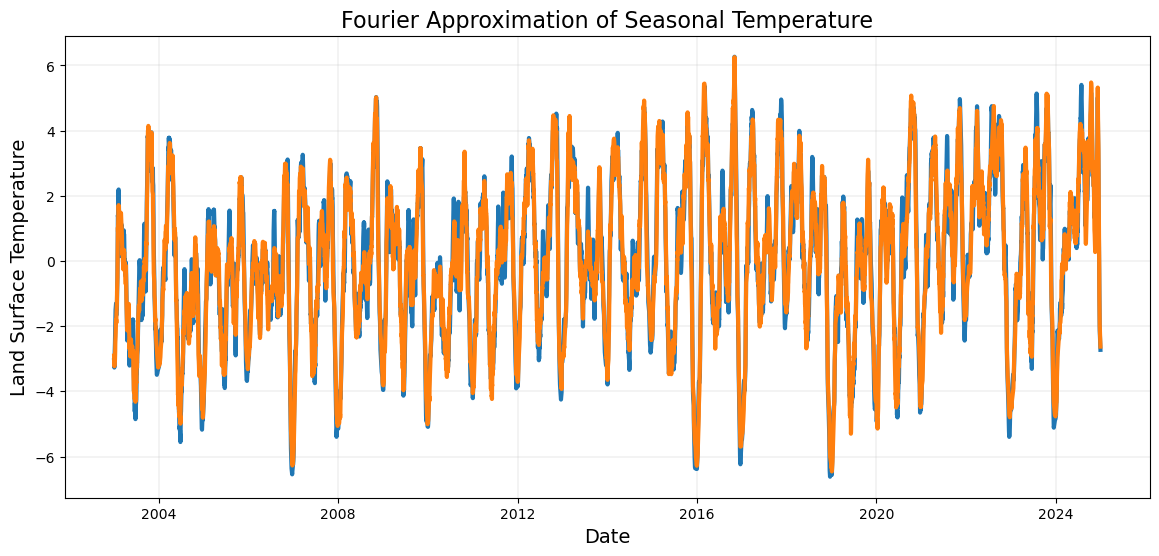

44.99405179878513
LinregressResult(slope=np.float64(0.00030951939483128015), intercept=np.float64(44.07911246766386), rvalue=np.float64(0.1005918502909675), pvalue=np.float64(8.964032529804525e-15), stderr=np.float64(3.981861470570614e-05), intercept_stderr=np.float64(0.13591841737817079))

made it here



<Figure size 640x480 with 0 Axes>

In [244]:
# Subplots
fig6, ax6 = plt.subplots(figsize=(14, 6))

ax6.plot(lst_subset_smoothed['datetime'], lst_norm - y_full, linewidth=3)
ax6.plot(lst_subset_smoothed['datetime'], lst_norm - (y_comp_1 + y_comp_2 + y_comp_3 + y_comp_4), linewidth = 3)
# Add some parameters
ax6.set_title('Fourier Approximation of Seasonal Temperature', fontsize=16)
ax6.set_xlabel('Date', fontsize=14)
ax6.set_ylabel('Land Surface Temperature', fontsize=14)
#ax6.set_ylim(-0.3, 0.5)
#ax6.set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2024-12-31'))
ax6.grid(lw=0.2)
plt.show()
plt.savefig('fourier_error.png')

print(np.mean((lst_subset_smoothed['LST_1KM'] - y_full)))

print(linregress(np.arange(0,n_samp), lst_subset_smoothed['LST_1KM'] - y_full))

print('\nmade it here\n')